# **Laboratorio 8**

-  [Mónica Salvatierra - 22249](https://github.com/alee2602)
- [Paula Barillas - 22764](https://github.com/paulabaal12)
- [Derek Arreaga - 22537](https://github.com/FabianKel)

**Link del repositorio:**

https://github.com/FabianKel/LAB8-IA

## **Task 1 - Teoría**

Responda las siguientes preguntas de forma clara y concisa

**1. Investigar el algoritmo AC-3 y su relación con el algoritmo de
backtracking search.**


El algoritmo AC-3 es una técnica utilizada en problemas de
restricciones para reducir los dominios de las variables
eliminando valores inconsistentes. Al igual que el algoritmo de
Backtracking Search, tiene como objetivo mejorar la eficiencia
de la búsqueda al reducir el espacio de soluciones antes de
aplicar métodos más costosos.
El algoritmo AC-3 funciona de la siguiente manera:
1. Convierte restricciones en arco: Se representan las
restricciones binarias como pares de arcos (X -> Y, Y ->X)
2. Se crea una agenda de arcos: Se almacena una lista de arcos
a revisar.
3. Revisión de arcos: Se verifica si cada valor en el dominio de
una variable tiene al menos un valor compatible en la otra
variable. Si un valor no tiene soporte, se elimina.
4. Repetición hasta encontrar estabilidad: Si un dominio
cambia, entonces los arcos relacionados se deben de volver
a revisar y el proceso continúa hasta que no haya más
modificaciones.

**Ventajas:**
- Reduce el espacio de búsqueda, facilitando la solución
del problema.
- Detecta inconsistencias temprano, evitando
exploraciones inútiles.

**Desventajas:**
- No garantiza una solución óptima, solo filtra valores
inconsistentes.
- Puede ser costoso en problemas con grandes dominios o
muchas restricciones.


**2. Defina en sus propias palabras el término “Arc Consistency”**

Arc Consistency es un concepto que se utiliza en problemas de satisfacción de restricciones. Se dice que un arco entre dos variables es consistente cuando, para cada valor en el dominio de la primera variable, existe al menos un valor en el dominio de la segunda que cumple con la restricción que hay entre ellas. Si no se cumple esto, se eliminan los valores que no sirven, de tal manera que se van reduciendo los dominios y se facilita la búsqueda de una solución al problema.

### **Referencias**

1. Boris. (2025, 28 febrero). ARC consistency explained. BorisTheBrave.Com. https://www.boristhebrave.com/2021/08/30/arc-consistency-explained/

2. Satisfacción de restricciones: algoritmo AC-3. (2024, 2 marzo).
https://www.toolify.ai/es/ai-news-es/satisfaccin-de-
restricciones-algoritmo-ac3-2042502


## **Task 2 - CSP con Backtracking, Beam y Local Search**

In [70]:
import time
import random
from enum import Enum
import tabulate
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd




**Definición de variables y dominio**

In [71]:
exams = ["Cocina", "Inglés", "Matemáticas", "Historia", "Arte", "Física", "Química"]

# Dominio = Días disponibles
domain = ["Lunes", "Martes", "Miércoles"]

# Asignación de exámenes por estudiante
students = {
    "Carlos": ["Cocina", "Inglés", "Matemáticas"],
    "Max": ["Matemáticas", "Historia", "Arte"],
    "Charles": ["Matemáticas", "Arte", "Física"],
    "Lewis": ["Cocina", "Arte", "Química"]
}

# Crear una lista de pares (estudiante, examen)
student_exam_pairs = [(student, exam) for student, exams in students.items() for exam in exams]

# información de los exámenes
exams_df = pd.DataFrame({'Asignatura': exams})

print("\nExámenes a programar:")
print(exams_df)

# Mostrar información de los estudiantes
student_data = []
for student, student_exams in students.items():
    student_data.append([student, ", ".join(student_exams)])
    
print("\nEstudiantes y sus exámenes:")
print(tabulate.tabulate(student_data, headers=["Estudiante", "Exámenes"], tablefmt="grid"))
    
print("\nRestricciones:")
print("1. Todos los exámenes deben realizarse en días diferentes (Lunes, Martes o Miércoles)")
print("2. Ningún estudiante puede tener más de un examen en un mismo día")
print("3. Estudiantes que toman el mismo curso no pueden tener exámenes el mismo día")




Exámenes a programar:
    Asignatura
0       Cocina
1       Inglés
2  Matemáticas
3     Historia
4         Arte
5       Física
6      Química

Estudiantes y sus exámenes:
+--------------+-----------------------------+
| Estudiante   | Exámenes                    |
+==============+=============================+
| Carlos       | Cocina, Inglés, Matemáticas |
+--------------+-----------------------------+
| Max          | Matemáticas, Historia, Arte |
+--------------+-----------------------------+
| Charles      | Matemáticas, Arte, Física   |
+--------------+-----------------------------+
| Lewis        | Cocina, Arte, Química       |
+--------------+-----------------------------+

Restricciones:
1. Todos los exámenes deben realizarse en días diferentes (Lunes, Martes o Miércoles)
2. Ningún estudiante puede tener más de un examen en un mismo día
3. Estudiantes que toman el mismo curso no pueden tener exámenes el mismo día


#### **Definir la restricción**

In [72]:
def constraints(assignment):
    # Restricción 1: Ningún estudiante puede tener más de un examen en el mismo día
    for student in students:
        days = [assignment.get((student, exam)) for exam in students[student] if (student, exam) in assignment]
        if len(days) != len(set(days)):  # Si hay días repetidos, hay conflicto
            return False
    
    # Restricción 2: Estudiantes que comparten un curso no pueden tener el mismo examen el mismo día
    for (student1, exam1), day1 in assignment.items():
        for (student2, exam2), day2 in assignment.items():
            if student1 != student2 and exam1 == exam2 and day1 == day2:
                return False
    
    return True

# Función para contar el número de conflictos
def count_conflicts(assignment):
        conflicts = 0
        
        # Restricción 1: Ningún estudiante puede tener más de un examen en el mismo día
        for student, student_exams in students.items():
            days = [assignment.get((student, exam)) for exam in student_exams if (student, exam) in assignment]
            conflicts += len(days) - len(set(days))
        
        # Restricción 2: Estudiantes que comparten un curso no pueden tener el mismo examen el mismo día
        for (i, (student1, exam1)) in enumerate(assignment):
            day1 = assignment[(student1, exam1)]
            for (student2, exam2) in list(assignment)[i+1:]:
                day2 = assignment[(student2, exam2)]
                if exam1 == exam2 and day1 == day2:
                    conflicts += 1
        
        return conflicts

# mostrar la solución de forma clara
# Crear tabla de asignación por día
def print_solution(solution, algorithm_name, execution_time):
    if not solution:
        return "No se encontró solución."
    
    print(f"\n{'=' * 40}")
    print(f"RESULTADOS DEL ALGORITMO: {algorithm_name}")
    print(f"Tiempo de ejecución: {execution_time:.6f} segundos")
    print(f"{'=' * 40}")
    
    # Crear tabla de asignación por día
    print("\nASIGNACIÓN DE EXÁMENES POR DÍA:")
    print("-" * 40)
    
    table_data = []
    for day in domain:
        exams_on_day = [
            f"{student}: {exam}" for (student, exam), d in solution.items() if d == day
        ]
        table_data.append([day, "\n".join(exams_on_day)])
    
    headers = ["Día", "Exámenes"]
    print(tabulate.tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

    calendar_data = []
    for student, student_exams in students.items():
        row = [student]
        for day in domain:
            exams_on_day = [
                exam for exam in student_exams if (student, exam) in solution and solution[(student, exam)] == day
            ]
            row.append("\n".join(exams_on_day) if exams_on_day else "")
        calendar_data.append(row)
    
    calendar_headers = ["Estudiante"] + domain
    print(tabulate.tabulate(calendar_data, headers=calendar_headers, tablefmt="fancy_grid"))
    
    return ""

# Función para medir tiempo 
def measure_execution_time(algorithm_func, *args, **kwargs):
    # Ejecutar el algoritmo varias veces para obtener un tiempo más preciso
    num_runs = 8
    total_time = 0
    solution = None
    
    for _ in range(num_runs):
        start_time = time.time()
        solution = algorithm_func(*args, **kwargs)
        end_time = time.time()
        total_time += (end_time - start_time)

    avg_time = total_time / num_runs
    if avg_time < 0.0001: 
        start_time = time.time()
        counter = 0
        while counter < 100:  
            solution = algorithm_func(*args, **kwargs)
            counter += 1
        end_time = time.time()
        avg_time = (end_time - start_time) / 100
    
    return solution, avg_time

#### **Algoritmo de Backtracking Search**

In [73]:
def backtracking(assignment=None, unassigned=None):
    if assignment is None:
        assignment = {}
        unassigned = student_exam_pairs.copy()
    
    if not unassigned:
        return assignment
    
    # Seleccionar el siguiente (estudiante, examen) a asignar
    student_exam = unassigned[0]
    
    for day in domain:
        assignment[student_exam] = day  # Asignar directamente
        
        if constraints(assignment):
            result = backtracking(assignment, unassigned[1:])
            if result:
                return result
        
        # Si no funcionó, deshacer el cambio 
        del assignment[student_exam]
    
    return None

# Ejecutar el algoritmo de Backtracking

bt_solution, bt_time = measure_execution_time(backtracking)
print_solution(bt_solution, "BACKTRACKING", bt_time)


RESULTADOS DEL ALGORITMO: BACKTRACKING
Tiempo de ejecución: 0.000418 segundos

ASIGNACIÓN DE EXÁMENES POR DÍA:
----------------------------------------
╒═══════════╤══════════════════════╕
│ Día       │ Exámenes             │
╞═══════════╪══════════════════════╡
│ Lunes     │ Carlos: Cocina       │
│           │ Max: Matemáticas     │
│           │ Charles: Arte        │
│           │ Lewis: Química       │
├───────────┼──────────────────────┤
│ Martes    │ Carlos: Inglés       │
│           │ Max: Historia        │
│           │ Charles: Matemáticas │
│           │ Lewis: Arte          │
├───────────┼──────────────────────┤
│ Miércoles │ Carlos: Matemáticas  │
│           │ Max: Arte            │
│           │ Charles: Física      │
│           │ Lewis: Cocina        │
╘═══════════╧══════════════════════╛
╒══════════════╤═════════════╤═════════════╤═════════════╕
│ Estudiante   │ Lunes       │ Martes      │ Miércoles   │
╞══════════════╪═════════════╪═════════════╪═════════════╡
│ Ca

''

#### **Algoritmo de Beam Search**

In [74]:
def beam_search(k=2):
    beam = [{}]  # Comenzamos con una asignación vacía
    unassigned = student_exam_pairs.copy()  
    
    # Para cada par (estudiante, examen) no asignado
    for student_exam in unassigned:
        new_beam = []
        
        # Para cada asignación parcial en el beam actual
        for assignment in beam:
            for day in domain:
                # Crear una nueva asignación con este par en este día
                new_assignment = assignment.copy()
                new_assignment[student_exam] = day
                
                # Verificar si esta asignación es consistente con las restricciones
                if constraints(new_assignment):
                    new_beam.append(new_assignment)
        
        # Si no hay asignaciones consistentes, no hay solución
        if not new_beam:
            return None
        
        # Ordenar las nuevas asignaciones utilizando una heurística 
        beam = sorted(new_beam, key=lambda x: count_conflicts(x))[:k]
    
    return beam[0] if beam else None

# Ejecutar el algoritmo de Beam Search
bs_solution, bs_time = measure_execution_time(beam_search, k=3)
print_solution(bs_solution, "BEAM SEARCH", bs_time)


RESULTADOS DEL ALGORITMO: BEAM SEARCH
Tiempo de ejecución: 0.001974 segundos

ASIGNACIÓN DE EXÁMENES POR DÍA:
----------------------------------------
╒═══════════╤══════════════════════╕
│ Día       │ Exámenes             │
╞═══════════╪══════════════════════╡
│ Lunes     │ Carlos: Cocina       │
│           │ Max: Matemáticas     │
│           │ Charles: Arte        │
│           │ Lewis: Química       │
├───────────┼──────────────────────┤
│ Martes    │ Carlos: Inglés       │
│           │ Max: Historia        │
│           │ Charles: Matemáticas │
│           │ Lewis: Arte          │
├───────────┼──────────────────────┤
│ Miércoles │ Carlos: Matemáticas  │
│           │ Max: Arte            │
│           │ Charles: Física      │
│           │ Lewis: Cocina        │
╘═══════════╧══════════════════════╛
╒══════════════╤═════════════╤═════════════╤═════════════╕
│ Estudiante   │ Lunes       │ Martes      │ Miércoles   │
╞══════════════╪═════════════╪═════════════╪═════════════╡
│ Car

''

#### **Algoritmo de Local Search**

In [75]:
def local_search(max_iterations=1000):
    # Genera una asignación inicial aleatoria
    current = {student_exam: random.choice(domain) for student_exam in student_exam_pairs}
    best_conflicts = float('inf')
    best_solution = None
    
    # Iteraciones de búsqueda local
    for _ in range(max_iterations):
        current_conflicts = count_conflicts(current)
        
        # Si es mejor que la mejor encontrada, actualizarla
        if current_conflicts < best_conflicts:
            best_conflicts = current_conflicts
            best_solution = current.copy()
            
        # Si no hay conflictos, hemos encontrado una solución
        if current_conflicts == 0:
            return current
        
        # Generar un vecino cambiando un par (estudiante, examen) aleatorio a un día aleatorio
        student_exam = random.choice(student_exam_pairs)
        current_day = current[student_exam]
        
        # Elegir un día diferente
        new_day = random.choice([d for d in domain if d != current_day])
        
        # Crear el vecino
        neighbor = current.copy()
        neighbor[student_exam] = new_day
        
        # Evaluar el vecino
        neighbor_conflicts = count_conflicts(neighbor)
        
        # Si el vecino es mejor, movernos a él
        if neighbor_conflicts <= current_conflicts:
            current = neighbor
    
    return best_solution

# Ejecutar el algoritmo de Local Search
ls_solution, ls_time = measure_execution_time(local_search, max_iterations=1000)
print_solution(ls_solution, "LOCAL SEARCH", ls_time)


RESULTADOS DEL ALGORITMO: LOCAL SEARCH
Tiempo de ejecución: 0.008450 segundos

ASIGNACIÓN DE EXÁMENES POR DÍA:
----------------------------------------
╒═══════════╤══════════════════════╕
│ Día       │ Exámenes             │
╞═══════════╪══════════════════════╡
│ Lunes     │ Carlos: Cocina       │
│           │ Max: Arte            │
│           │ Charles: Matemáticas │
│           │ Lewis: Química       │
├───────────┼──────────────────────┤
│ Martes    │ Carlos: Inglés       │
│           │ Max: Matemáticas     │
│           │ Charles: Física      │
│           │ Lewis: Arte          │
├───────────┼──────────────────────┤
│ Miércoles │ Carlos: Matemáticas  │
│           │ Max: Historia        │
│           │ Charles: Arte        │
│           │ Lewis: Cocina        │
╘═══════════╧══════════════════════╛
╒══════════════╤═════════════╤═════════════╤═════════════╕
│ Estudiante   │ Lunes       │ Martes      │ Miércoles   │
╞══════════════╪═════════════╪═════════════╪═════════════╡
│ Ca

''

#### **Comparación de resultados**

{('Carlos', 'Cocina'): 'Lunes',
 ('Carlos', 'Inglés'): 'Martes',
 ('Carlos', 'Matemáticas'): 'Miércoles',
 ('Max', 'Matemáticas'): 'Lunes',
 ('Max', 'Historia'): 'Martes',
 ('Max', 'Arte'): 'Miércoles',
 ('Charles', 'Matemáticas'): 'Martes',
 ('Charles', 'Arte'): 'Lunes',
 ('Charles', 'Física'): 'Miércoles',
 ('Lewis', 'Cocina'): 'Miércoles',
 ('Lewis', 'Arte'): 'Martes',
 ('Lewis', 'Química'): 'Lunes'}

0.00041826963424682615

{('Carlos', 'Cocina'): 'Lunes',
 ('Carlos', 'Inglés'): 'Martes',
 ('Carlos', 'Matemáticas'): 'Miércoles',
 ('Max', 'Matemáticas'): 'Lunes',
 ('Max', 'Historia'): 'Martes',
 ('Max', 'Arte'): 'Miércoles',
 ('Charles', 'Matemáticas'): 'Martes',
 ('Charles', 'Arte'): 'Lunes',
 ('Charles', 'Física'): 'Miércoles',
 ('Lewis', 'Cocina'): 'Miércoles',
 ('Lewis', 'Arte'): 'Martes',
 ('Lewis', 'Química'): 'Lunes'}

0.0019738972187042236

{('Carlos', 'Cocina'): 'Lunes',
 ('Carlos', 'Inglés'): 'Martes',
 ('Carlos', 'Matemáticas'): 'Miércoles',
 ('Max', 'Matemáticas'): 'Martes',
 ('Max', 'Historia'): 'Miércoles',
 ('Max', 'Arte'): 'Lunes',
 ('Charles', 'Matemáticas'): 'Lunes',
 ('Charles', 'Arte'): 'Miércoles',
 ('Charles', 'Física'): 'Martes',
 ('Lewis', 'Cocina'): 'Miércoles',
 ('Lewis', 'Arte'): 'Martes',
 ('Lewis', 'Química'): 'Lunes'}

0.008450418710708618


RESUMEN COMPARATIVO DE ALGORITMOS:
╒══════════════╤═══════════════════════╤════════════════════╕
│ Algoritmo    │ Tiempo de Ejecución   │ Tipo de Solución   │
╞══════════════╪═══════════════════════╪════════════════════╡
│ Backtracking │ 0.000418 s            │ Aproximada         │
├──────────────┼───────────────────────┼────────────────────┤
│ Beam Search  │ 0.001974 s            │ Aproximada         │
├──────────────┼───────────────────────┼────────────────────┤
│ Local Search │ 0.008450 s            │ Aproximada         │
╘══════════════╧═══════════════════════╧════════════════════╛


<Figure size 1000x600 with 0 Axes>

<BarContainer object of 3 artists>

Text(0.5, 0, 'Algoritmo')

Text(0, 0.5, 'Tiempo de Ejecución (segundos)')

Text(0.5, 1.0, 'Comparación de Tiempos de Ejecución de Algoritmos')

(0.0, 0.004225209355354309)

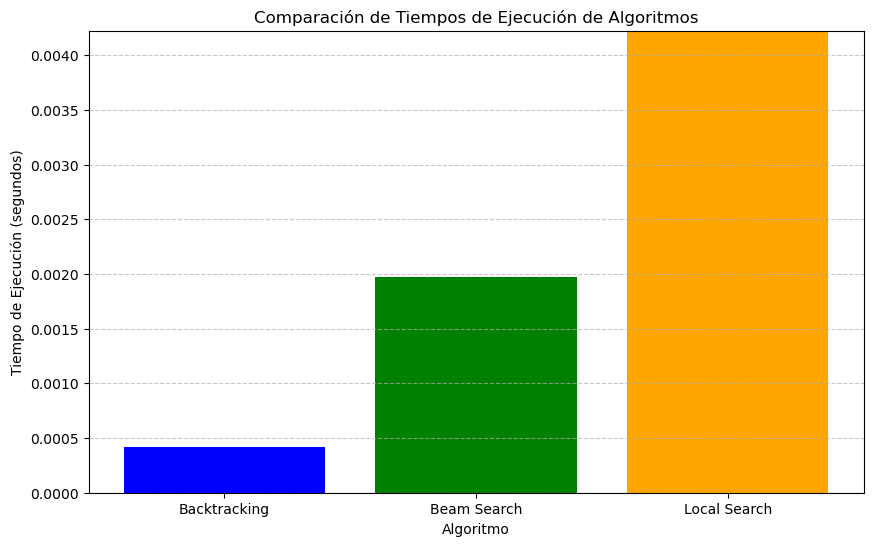

In [76]:
import matplotlib.pyplot as plt

# Comparación de resultados
try:
    bt_solution
    bt_time
except NameError:
    print("Ejecutando Backtracking para comparación...")
    bt_solution, bt_time = measure_execution_time(backtracking)

try:
    bs_solution
    bs_time
except NameError:
    print("Ejecutando Beam Search para comparación...")
    bs_solution, bs_time = measure_execution_time(beam_search, k=3)

try:
    ls_solution
    ls_time
except NameError:
    print("Ejecutando Local Search para comparación...")
    ls_solution, ls_time = measure_execution_time(local_search, max_iterations=2000)

# Resumen comparativo
print("\nRESUMEN COMPARATIVO DE ALGORITMOS:")
print("=" * 60)

comparison_data = [
    ["Backtracking", f"{bt_time:.6f} s", "Aproximada" if bt_solution else "No encontrada"],
    ["Beam Search", f"{bs_time:.6f} s", "Aproximada" if bs_solution else "No encontrada"],
    ["Local Search", f"{ls_time:.6f} s", "Aproximada" if ls_solution else "No encontrada"]
]

headers = ["Algoritmo", "Tiempo de Ejecución", "Tipo de Solución"]
print(tabulate.tabulate(comparison_data, headers=headers, tablefmt="fancy_grid"))

# gráfico de barras para los tiempos de ejecución
algorithms = ["Backtracking", "Beam Search", "Local Search"]
times = [bt_time, bs_time, ls_time]

plt.figure(figsize=(10, 6))
plt.bar(algorithms, times, color=['blue', 'green', 'orange'])
plt.xlabel("Algoritmo")
plt.ylabel("Tiempo de Ejecución (segundos)")
plt.title("Comparación de Tiempos de Ejecución de Algoritmos")
plt.ylim(0, max(times) * 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **Conclusiones**

El tiempo de ejecución promedio de cada algoritmo fue el siguiente:
- **Backtracking**: aproximadamente 0.000418 segundos.
- **Beam Search**: aproximadamente 0.001974 segundos.
- **Local Search**: aproximadamente 0.008450 segundos.

**Backtracking** fue el más rápido, seguido de **Beam Search** y luego **Local Search**, que fue el más lento entre los tres.  
Esto era esperado, ya que Backtracking explora el espacio de búsqueda de forma ordenada y eficiente, sobretodo si el espacio de búsqueda no es exhaustivamente grande, mientras que Beam Search y Local Search dependen de estrategias de exploración heurística y de la asignación inicial para determinar los costos en términos de tiempo.

#### **Solución Encontrada**
Todas las soluciones generadas por los algoritmos cumplen las restricciones del problema:
- Todos los examenes se realizan en días diferentes.
- Ningún estudiante tiene más de un examen el mismo día.
- Estudiantes que comparten un curso no tienen el mismo examen en el mismo día.

Sin embargo, debido a la naturaleza aleatoria en Local Search, las asignaciones específicas de exámenes a días pueden variar en cada ejecución.  
Backtracking tiende a encontrar una solución válida de manera más consistente y rápida debido a su exploración sistemática, mientras que Beam Search y Local Search pueden explorar caminos alternativos que también son válidos, pero toman más tiempo.

#### **Observaciones**
- **Backtracking** es muy eficiente para este tamaño de problema (pocos estudiantes y exámenes).
- **Beam Search** proporciona una buena solución, pero depende mucho del valor de `k` y puede variar en calidad.
- **Local Search** tiende a encontrar soluciones válidas, pero es más lento porque explora el espacio de soluciones aleatoriamente y depende de una buena función de conflictos.

Dado el pequeño tamaño del problema, **Backtracking** sería el algoritmo de preferencia para este contexto en específico.
Para problemas más grandes, sería recomendable utilizar técnicas como **Beam Search** o **Local Search** para evitar tiempos de ejecución largos.